In [1]:
"""Resnet model for classification of real and fake images."""
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import PIL as image_lib
import tensorflow as tflow
from tensorflow.keras.layers import Flatten
from keras.layers.core import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plotter_lib
import numpy as np
import PIL as image_lib
import tensorflow as tflow
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.layers import Flatten
from keras.layers.core import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import time
import gc
from PIL import Image
# Timing the script

script_time = time.time()

In [2]:
AUTOTUNE = tflow.data.AUTOTUNE

In [3]:
IMAGE_SIZE = (256, 256)  # height, width
batch_size = 128  # 32 is default recommendation for vision models

In [4]:
train_ds = tflow.keras.preprocessing.image_dataset_from_directory(
    "T9-Train",
    label_mode="binary",
    # validation_split=val_ratio,
    shuffle=True,
    # subset="training",
    seed=417,
    image_size=IMAGE_SIZE,
    batch_size=batch_size,  # Changed from batch_size 32 to none
    # color_mode="grayscale",
)

Found 100796 files belonging to 2 classes.


In [5]:
validation_ds = tflow.keras.preprocessing.image_dataset_from_directory(
    "T9-Val",
    # validation_split=val_ratio,
    shuffle=True,
    # subset="validation",
    seed=417,
    label_mode="binary",
    image_size=IMAGE_SIZE,
    batch_size=batch_size,  # Changed from batch_size 32 to none
    # color_mode="grayscale",
)

Found 11200 files belonging to 2 classes.


In [6]:
train_ds_and_val_ds = train_ds.concatenate(validation_ds)

In [7]:
count = 0
img_gs = []
label_gs = []
for img, label in train_ds_and_val_ds.take(-1):
    count += 1
    img_gs.append(img.numpy())
    label_gs.append(label.numpy())

print(f"Number of batches in TrainplusVal: {count}")

Number of batches in TrainplusVal: 876


In [8]:
train_ds_and_val_ds.shuffle(count, reshuffle_each_iteration=False)
del count, img_gs, label_gs
gc.collect()

0

In [9]:
test_ds = tflow.keras.preprocessing.image_dataset_from_directory(
    "T9-Test",
    label_mode="binary",
    shuffle=True,
    seed=417,
    image_size=IMAGE_SIZE,
    batch_size=batch_size,  # Changed from batch_size 32 to none
    # color_mode="grayscale",
)

Found 28000 files belonging to 2 classes.


In [10]:
epochs = 10

In [11]:
demo_resnet_model = tflow.keras.models.load_model("demo_resnet_model_140K.h5")

In [12]:
history = demo_resnet_model.fit(
    train_ds_and_val_ds,
    # validation_data=validation_ds,
    epochs=epochs,
    verbose=1,
    shuffle=False,  # For reproducibility
    # callbacks=[tflow.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
)

Epoch 1/10
876/876 [==============================] - 227s 252ms/step - loss: 0.0629 - accuracy: 0.9766 - auc: 0.9972 - precision: 0.9783 - recall: 0.9748 - true_positives: 54586.0000 - true_negatives: 54786.0000 - false_positives: 1211.0000 - false_negatives: 1413.0000
Epoch 2/10
876/876 [==============================] - 234s 267ms/step - loss: 0.0584 - accuracy: 0.9784 - auc: 0.9976 - precision: 0.9798 - recall: 0.9769 - true_positives: 54705.0000 - true_negatives: 54869.0000 - false_positives: 1128.0000 - false_negatives: 1294.0000
Epoch 3/10
876/876 [==============================] - 234s 267ms/step - loss: 0.0452 - accuracy: 0.9836 - auc: 0.9985 - precision: 0.9847 - recall: 0.9824 - true_positives: 55013.0000 - true_negatives: 55142.0000 - false_positives: 855.0000 - false_negatives: 986.0000
Epoch 4/10
876/876 [==============================] - 234s 267ms/step - loss: 0.0415 - accuracy: 0.9849 - auc: 0.9988 - precision: 0.9858 - recall: 0.9839 - true_positives: 55097.0000 - tru

In [13]:
demo_resnet_model.save("demo_resnet_model_140K_tr_val_rgb.h5")
demo_resnet_model.save_weights("demo_resnet_model_140K_tr_val_rgb_weights.h5")

In [14]:
ims = []
labs = []
probs = []
preds = []

In [16]:
ims = []
labs = []
probs = []
preds = []
for image, label in test_ds:
    ims.append(image)
    labs.append(label)
    probs.append(demo_resnet_model.predict(image))
    preds.append(np.round(demo_resnet_model.predict(image)))

ims = np.concatenate(ims, axis=0)
labs = np.concatenate(labs, axis=0)
probs = np.concatenate(probs, axis=0)
preds = np.concatenate(preds, axis=0)
misclassifieds = np.where(labs != preds)[0]
misc_ims = ims[misclassifieds]
misc_labs = labs[misclassifieds]
im_labels = zip(misc_ims, misc_labs)

3/3 [==============================] - 0s 63ms/step


In [17]:
iter_for_name = 0
for im, lab in im_labels:
    if lab == 0:
        flag = "Fake"
    else:
        flag = "Real"
    reconstructed_image = Image.fromarray((im * 1).astype(np.uint8)).convert("RGB")
    # use old ind for naming
    reconstructed_image.save(f"T9-Misc140KRGB\{flag}\{flag}{iter_for_name}.png")
    iter_for_name += 1

In [18]:
print(f"Number of misclassified images in the test set: {len(misc_labs)}")

Number of misclassified images in the test set: 1290


In [19]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(labs, preds))
print(confusion_matrix(labs, preds))

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95     14000
         1.0       0.94      0.97      0.95     14000

    accuracy                           0.95     28000
   macro avg       0.95      0.95      0.95     28000
weighted avg       0.95      0.95      0.95     28000

[[13126   874]
 [  416 13584]]


In [20]:
with open("test_classification_report.txt", "w") as f:
    f.write(str(classification_report(labs, preds)))
    f.close()

In [21]:
with open("test_confusion_matrix.txt", "w") as f:
    f.write(str(confusion_matrix(labs, preds)))
    f.close()

In [22]:
print(classification_report(labs, preds))

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95     14000
         1.0       0.94      0.97      0.95     14000

    accuracy                           0.95     28000
   macro avg       0.95      0.95      0.95     28000
weighted avg       0.95      0.95      0.95     28000



In [23]:
print(confusion_matrix(labs, preds))

[[13126   874]
 [  416 13584]]


In [49]:
import matplotlib.pyplot as plotter_lib
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import numpy as np

In [50]:
def roc_curve_T9(labels_ls, test_ds_pred):
    fpr, tpr, _ = roc_curve(labels_ls, test_ds_pred)
    auc_score = auc(fpr, tpr)
    # plot roc curve
    plotter_lib.plot(
        fpr,
        tpr,
        color="orange",
        label=f"ResNet50 (AUC = {auc_score:.3f})",
    )
    # axis labels
    # add random guessing line
    plotter_lib.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plotter_lib.xlabel("False Positive Rate")
    plotter_lib.ylabel("True Positive rate")
    plotter_lib.legend(loc="best")
    plotter_lib.title("ROC Curve on Test Set")
    plotter_lib.show()
    plt.savefig("TestROC_curve.png")

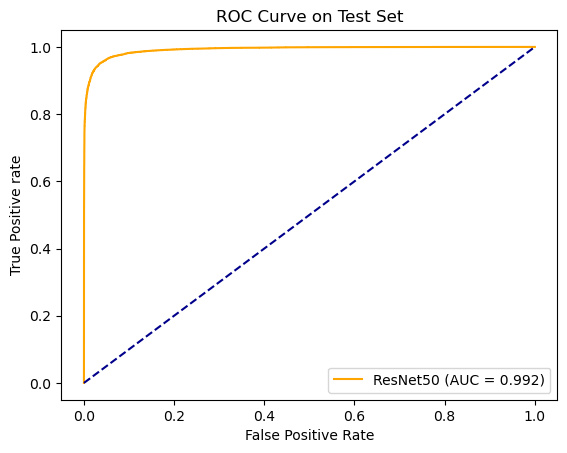

<Figure size 640x480 with 0 Axes>

In [51]:
roc_curve_T9(labs, probs)

In [52]:
def roc_curve_T9(labels_ls, test_ds_pred):
    fpr, tpr, _ = roc_curve(labels_ls, test_ds_pred)
    auc_score = auc(fpr, tpr)
    # plot roc curve
    plotter_lib.plot(
        fpr,
        tpr,
        color="orange",
        label=f"ResNet50 (AUC = {auc_score:.4f})",
    )
    # axis labels
    # add random guessing line
    plotter_lib.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plotter_lib.xlabel("False Positive Rate")
    plotter_lib.ylabel("True Positive rate")
    plotter_lib.legend(loc="best")
    plotter_lib.title("ROC Curve on Test Set")
    plotter_lib.show()

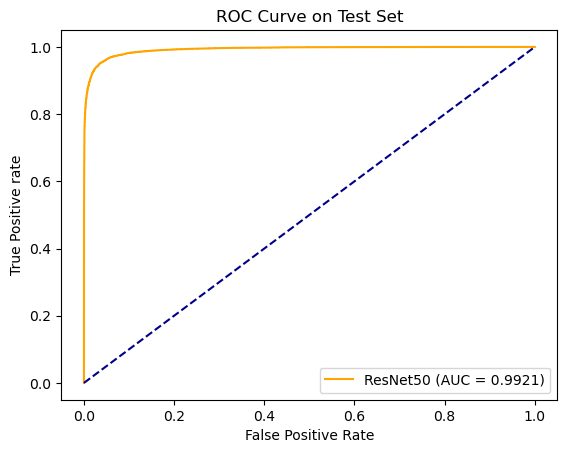

In [53]:
roc_curve_T9(labs, probs)

In [54]:
from sklearn.metrics import average_precision_score

In [55]:
def pr_curve_T9(labels_ls, test_ds_pred):
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(labels_ls[labels_ls == 1]) / len(labels_ls)
    # calculate model precision-recall curve
    precision, recall, _ = precision_recall_curve(labels_ls, test_ds_pred)
    # average precision score
    ap = average_precision_score(labels_ls, test_ds_pred)
    # plot the precision-recall curves
    plotter_lib.plot([0, 1], [no_skill, no_skill], linestyle="--", label="Random Chance")
    plotter_lib.plot(recall, precision, marker=".", label="ResNet50 (AP = %.4f)" % ap)
    # axis labels
    plotter_lib.xlabel("Recall")
    plotter_lib.ylabel("Precision")
    plotter_lib.title("Precision-Recall Curve on Test Set")
    plotter_lib.legend()
    plotter_lib.show()

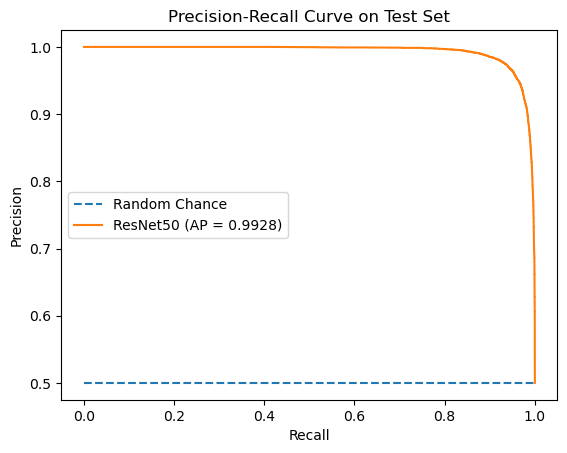

In [58]:
pr_curve_T9(labs, probs)

In [60]:
evaluation = demo_resnet_model.evaluate(test_ds, verbose=1, return_dict=True)
print(evaluation)
# write evaluation to file

with open("test_evaluation.txt", "w") as f:
    f.write(str(evaluation))
    f.write(str(test_ds.class_names))
    f.close()

219/219 [==============================] - 62s 273ms/step - loss: 0.1539 - accuracy: 0.9539 - auc: 0.9877 - precision: 0.9395 - recall: 0.9702 - true_positives: 13583.0000 - true_negatives: 13126.0000 - false_positives: 874.0000 - false_negatives: 417.0000
{'loss': 0.15392383933067322, 'accuracy': 0.9538928866386414, 'auc': 0.9876847267150879, 'precision': 0.9395448565483093, 'recall': 0.970214307308197, 'true_positives': 13583.0, 'true_negatives': 13126.0, 'false_positives': 874.0, 'false_negatives': 417.0}


In [61]:
evaluation

{'loss': 0.15392383933067322,
 'accuracy': 0.9538928866386414,
 'auc': 0.9876847267150879,
 'precision': 0.9395448565483093,
 'recall': 0.970214307308197,
 'true_positives': 13583.0,
 'true_negatives': 13126.0,
 'false_positives': 874.0,
 'false_negatives': 417.0}

In [64]:
demo_resnet_model.save("TrainValmodel/demo_resnet_model_140K_tr_val_rgb")

INFO:tensorflow:Assets written to: TrainValmodel/demo_resnet_model_140K_tr_val_rgb\assets


INFO:tensorflow:Assets written to: TrainValmodel/demo_resnet_model_140K_tr_val_rgb\assets


In [65]:
demo_resnet_model.optimizer

In [66]:
demo_resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)              

In [67]:
demo_resnet_model.save("demo_resnet_model_140K_tr_val_rgb.h5")
demo_resnet_model.save_weights("demo_resnet_model_140K_tr_val_rgb_weights.h5")

In [68]:
all_ds = train_ds_and_val_ds.concatenate(test_ds)

In [84]:
count = 0
for  im, label in all_ds.take(-1):
    count += im.shape[0]

In [85]:
print("The images in the dataset with all the data are: ", count)

The images in the dataset with all the data are:  139996


In [86]:
final_history = demo_resnet_model.fit(
    all_ds,
    # validation_data=validation_ds,
    epochs=epochs,
    verbose=1,
    shuffle=False,  # For reproducibility
    # callbacks=[tflow.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
)

Epoch 1/10
1095/1095 [==============================] - 300s 273ms/step - loss: 0.0557 - accuracy: 0.9810 - auc: 0.9972 - precision: 0.9814 - recall: 0.9805 - true_positives: 68636.0000 - true_negatives: 68696.0000 - false_positives: 1301.0000 - false_negatives: 1363.0000
Epoch 2/10
1095/1095 [==============================] - 298s 272ms/step - loss: 0.0443 - accuracy: 0.9840 - auc: 0.9982 - precision: 0.9850 - recall: 0.9830 - true_positives: 68812.0000 - true_negatives: 68951.0000 - false_positives: 1046.0000 - false_negatives: 1187.0000
Epoch 3/10
1095/1095 [==============================] - 298s 272ms/step - loss: 0.0359 - accuracy: 0.9874 - auc: 0.9988 - precision: 0.9880 - recall: 0.9868 - true_positives: 69075.0000 - true_negatives: 69161.0000 - false_positives: 836.0000 - false_negatives: 924.0000
Epoch 4/10
1095/1095 [==============================] - 298s 272ms/step - loss: 0.0323 - accuracy: 0.9887 - auc: 0.9991 - precision: 0.9895 - recall: 0.9879 - true_positives: 69152.00

In [87]:
demo_resnet_model.save("deploy_resnet_model_140K_alldata_rgb.h5")

In [88]:
demo_resnet_model.save_weights("deploy_resnet_model_140K_alldata_rgb_weights.h5")